# Setup

In [1]:
import itertools
import pandas as pd
import numpy as np
from random import gauss, shuffle 

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse
from scipy.stats import shapiro, probplot
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cluster import KMeans

import os
import lightgbm as lgb

from  datetime import datetime, timedelta
import gc, copy

from gensim.models import Word2Vec 

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [2]:
class CFG:
    data_folder = '../input/tsdata-1/'
    img_dim1 = 20
    img_dim2 = 10
        
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})    

# Functions

In [3]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x,y)) ,4))

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df



# Data

In [5]:
xdat = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_validation.csv')
xdat = xdat.loc[xdat.state_id == 'CA']
xdat.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [6]:

xdat = reduce_mem_usage(xdat)

Memory usage of dataframe is 178.65 MB
Memory usage after optimization is: 35.74 MB
Decreased by 80.0%


In [7]:
# melt the data into long format
xdat = pd.melt(xdat, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sales').dropna()

# get proper timestamps
xcal = pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv')
xdat = pd.merge(xdat, xcal, on='d', how='left')
del xcal

In [8]:
xdat.drop(['d', 'wm_yr_wk', 'weekday', 'month', 'year',  'event_name_1', 'event_type_1', 
           'event_name_2', 'event_type_2', 'snap_TX', 'snap_WI', 'state_id'], 
                  axis = 1, inplace = True)
xdat.head(3)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0


In [9]:
# for make benefit of speed
xdat = xdat.loc[xdat.date >= '2015-01-01']

# New launches

In [10]:
xtrain = pd.read_csv('../input/partial-visuelle/train.csv')
xtrain.head(3)

,0,1,2,3,4,5,6,7,8,9,...,category,release_date,day,week,month,year,image_path,color,fabric,extra
0,0.004695,0.073239,0.061972,0.066667,0.046009,0.043192,0.026291,0.019718,0.012207,0.014085,...,long sleeve,2016-12-01,0.500000,0.923077,1.0,0.998514,PE17/00001.png,yellow,acrylic,hem
1,0.005634,0.109859,0.128638,0.135211,0.082629,0.098592,0.063850,0.052582,0.034742,0.138967,...,long sleeve,2016-12-01,0.500000,0.923077,1.0,0.998514,PE17/00002.png,brown,acrylic,hem
2,0.002817,0.207512,0.177465,0.095775,0.041315,0.030047,0.015023,0.006573,0.010329,0.005634,...,culottes,2016-12-02,0.666667,0.923077,1.0,0.998514,PE17/00003.png,blue,scuba crepe,hem


In [11]:
xtest = pd.read_csv('../input/partial-visuelle/test.csv')
xtest.head(3)

,0,1,2,3,4,5,6,7,8,9,...,category,release_date,day,week,month,year,image_path,color,fabric,extra
0,0.032864,0.062911,0.054460,0.056338,0.042254,0.033803,0.037559,0.029108,0.016901,0.012207,...,short sleeves,2019-04-17,0.333333,0.307692,0.333333,1.0,PE19/05081.png,grey,georgette,hem
1,0.046948,0.060094,0.083568,0.117371,0.079812,0.089202,0.078873,0.061033,0.023474,0.015962,...,culottes,2019-04-17,0.333333,0.307692,0.333333,1.0,PE19/05082.png,red,bengaline,strapless
2,0.043192,0.086385,0.079812,0.080751,0.061972,0.062911,0.054460,0.045070,0.021596,0.015962,...,kimono dress,2019-04-17,0.333333,0.307692,0.333333,1.0,PE19/05083.png,white,frise,hem


In [12]:
xtrain.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       'external_code', 'season', 'category', 'release_date', 'day', 'week',
       'month', 'year', 'image_path', 'color', 'fabric', 'extra'],
      dtype='object')

## MultiOutput


In [13]:
# split into targets and variables we will use for clustering
target_cols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
cat_cols = ['category', 'day', 'week', 'month', 'color', 'fabric', 'extra' ]

y0, y1 = xtrain[target_cols].copy(), xtest[target_cols].copy()
x0, x1 = xtrain[cat_cols].copy(), xtest[cat_cols].copy()

In [14]:
# transforms categoricals
xdat = pd.concat([x0,x1], axis = 0)
xdat = pd.get_dummies(xdat)
x0 = xdat.iloc[:x0.shape[0]]
x1 = xdat.iloc[x0.shape[0]:]
del xdat

In [15]:
# fit the model
base_model = Ridge()
mo_base = MultiOutputRegressor(base_model, n_jobs=-1)

mo_base.fit(x0, y0)

mo_prediction = mo_base.predict(x1) 

In [16]:
print('(sort of) MSE: ' + str(np.round( np.sqrt(np.average((mo_prediction - y1)**2)) ,4  )))

(sort of) MSE: 0.0508


Let's have a look at a few examples:

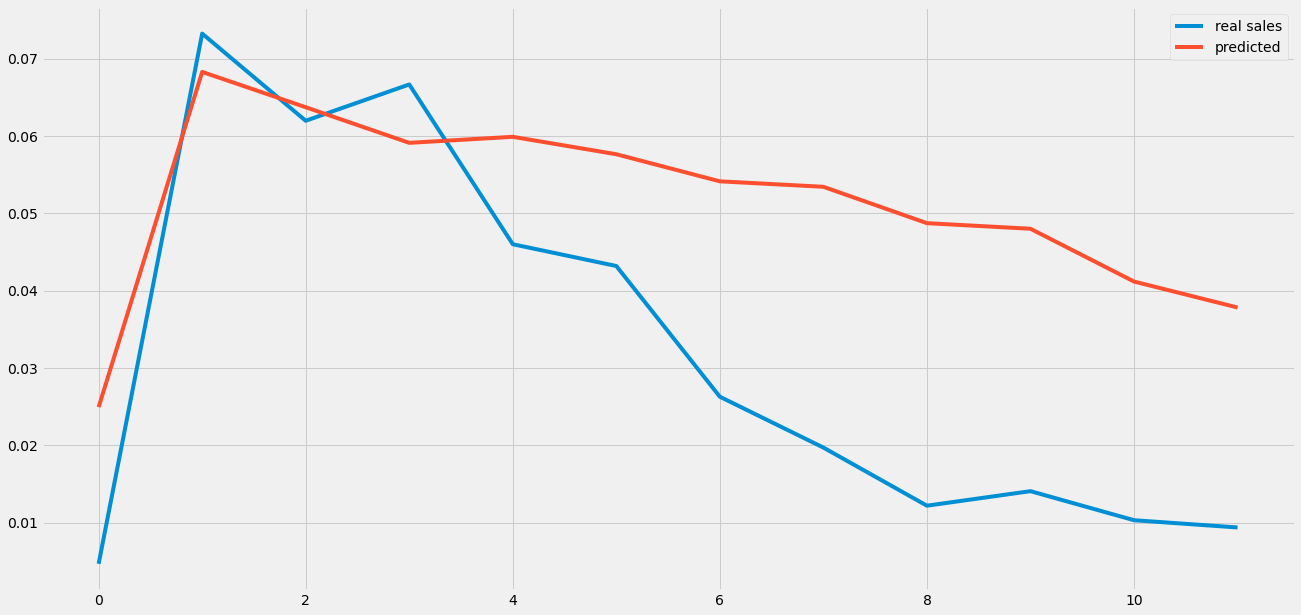

In [17]:
ii = 0 
plt.plot(y0.values[ii,:], label = "real sales")
plt.plot(mo_prediction[ii,:], label = "predicted")
plt.legend()
plt.show()

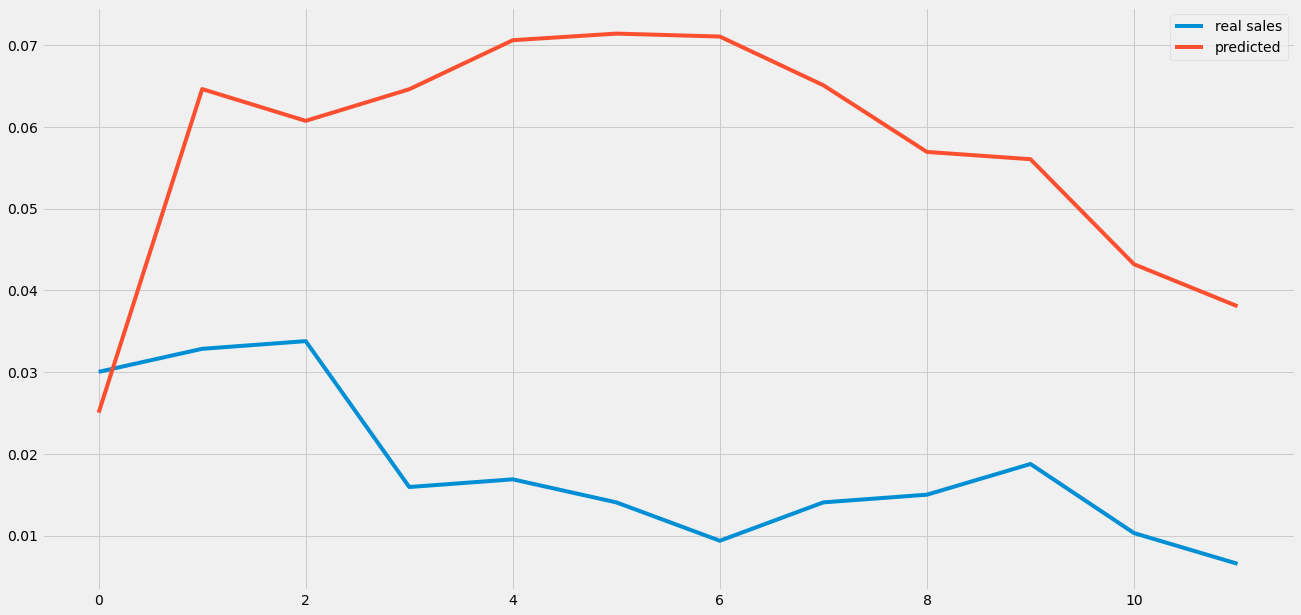

In [18]:
ii = 12
plt.plot(y0.values[ii,:], label = "real sales")
plt.plot(mo_prediction[ii,:], label = "predicted")
plt.legend()
plt.show()

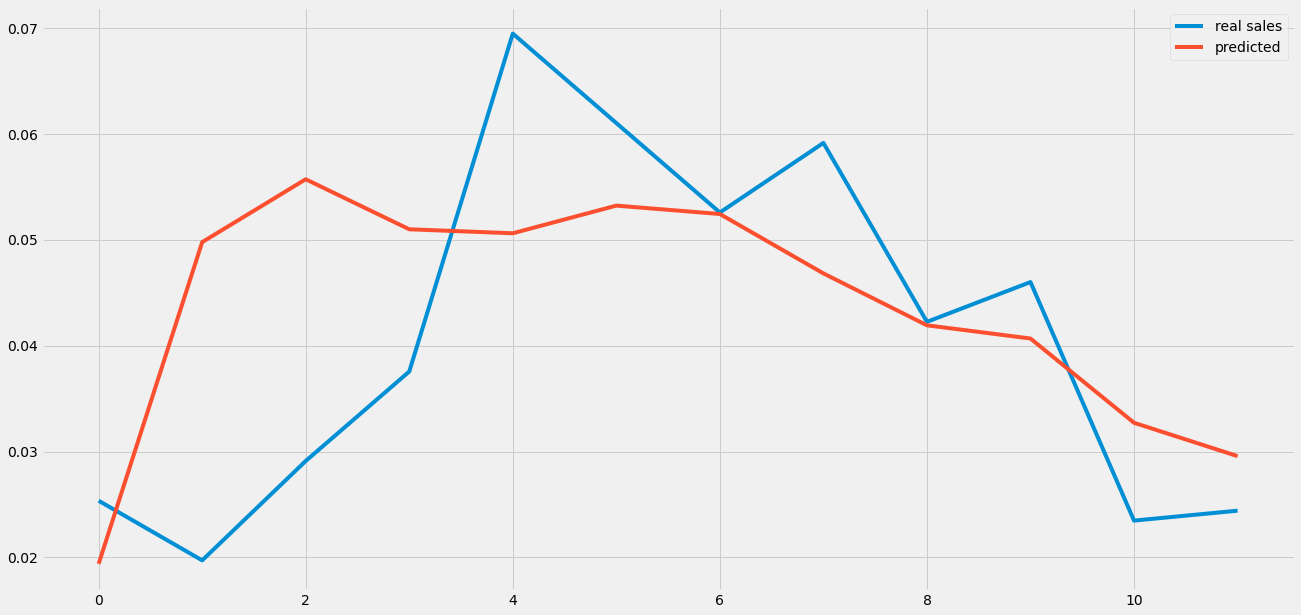

In [19]:
ii = 80
plt.plot(y0.values[ii,:], label = "real sales")
plt.plot(mo_prediction[ii,:], label = "predicted")
plt.legend()
plt.show()

## Embeddings

In [20]:
def correct_time(df):
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['week'] = df.release_date.dt.isocalendar().week
    df['month'] = df.release_date.dt.month
    df['day'] = df.release_date.dt.day
    
correct_time(xtrain)
correct_time(xtest)

In [21]:
# split into targets and variables we will use for clustering
target_cols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
cat_cols = ['category', 'day', 'week', 'month', 'color', 'fabric', 'extra' ]

y0, y1 = xtrain[target_cols].copy(), xtest[target_cols].copy()
x0, x1 = xtrain[cat_cols].copy(), xtest[cat_cols].copy()

### Cat2vec

In [22]:
# Taken from https://www.kaggle.com/code/classtag/cat2vec-powerful-feature-for-categorical


def apply_w2v(sentences, model, num_features):
    def _average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        n_words = 0.
        for word in words:
            if word in vocabulary: 
                n_words = n_words + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if n_words:
            feature_vector = np.divide(feature_vector, n_words)
        return feature_vector
    
    vocab = set(model.wv.index_to_key)
    feats = [_average_word_vectors(s, model, vocab, num_features) for s in sentences]
    return np.array(feats)

def gen_cat2vec_sentences(data):
    X_w2v = copy.deepcopy(data)
    names = list(X_w2v.columns.values)
    for c in names:
        X_w2v[c] = X_w2v[c].fillna('unknow').astype('category')
        X_w2v[c].cat.categories = ["%s %s" % (c,g) for g in X_w2v[c].cat.categories]
    X_w2v = X_w2v.values.tolist()
    return X_w2v

def fit_cat2vec_model(data):
    X_w2v = gen_cat2vec_sentences(data)
    for i in X_w2v:
        shuffle(i)
    model = Word2Vec(X_w2v, vector_size= 10, window= 3)
    return model

In [23]:
# fit a cat2vec
c2v_model = fit_cat2vec_model(pd.concat([x0,x1], axis = 0))

In [24]:
# generate the embeddings
x0_c2v = apply_w2v(gen_cat2vec_sentences(x0), c2v_model, 10)
x1_c2v = apply_w2v(gen_cat2vec_sentences(x1), c2v_model, 10)

### Clustering

In [25]:
# fit kmeans
clustering = KMeans(n_clusters = 10)
clustering.fit(x0_c2v)

y0_clusters = clustering.predict(x0_c2v)

In [26]:
# assign the clusters for the test set
y1_clusters = clustering.predict(x1_c2v)

### Mapping

In [27]:

cl_prediction = np.zeros(y1.shape)

for ii in range(10):
    cl_prediction[y1_clusters == ii,:] = y0.loc[y0_clusters == ii].mean()


In [28]:
print('(sort of) MSE: ' + str(np.round( np.sqrt(np.average((cl_prediction - y1)**2)) ,4  )))

(sort of) MSE: 0.0524


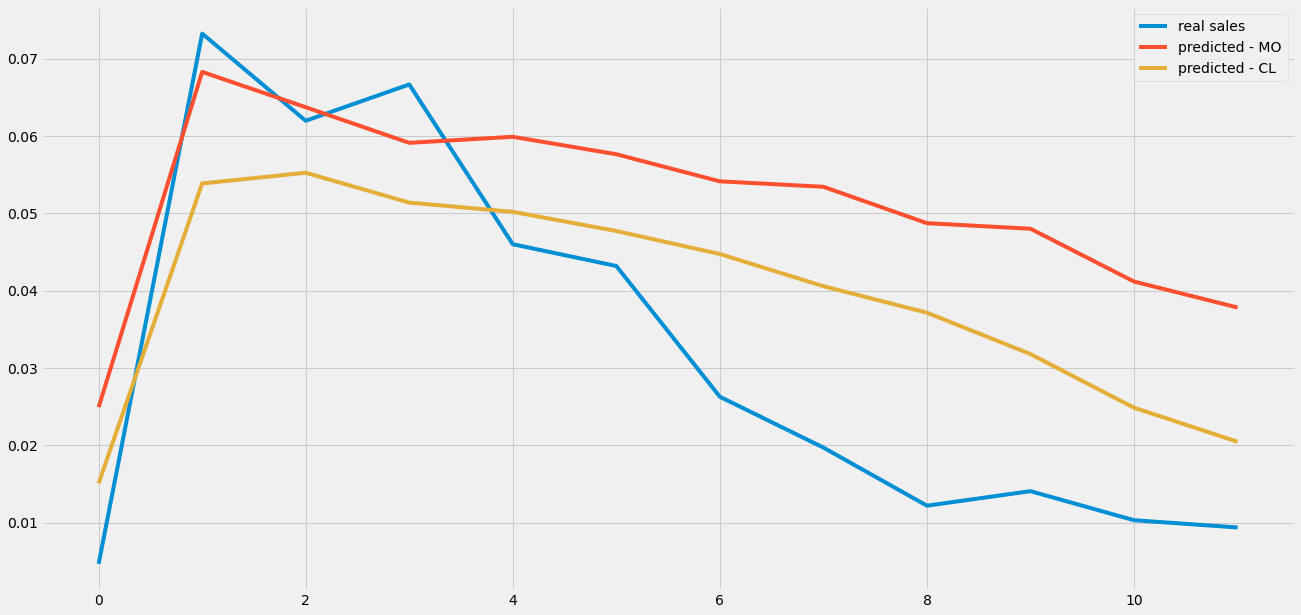

In [29]:
ii = 0 
plt.plot(y0.values[ii,:], label = "real sales")
plt.plot(mo_prediction[ii,:], label = "predicted - MO")
plt.plot(cl_prediction[ii,:], label = "predicted - CL")
plt.legend()
plt.show()

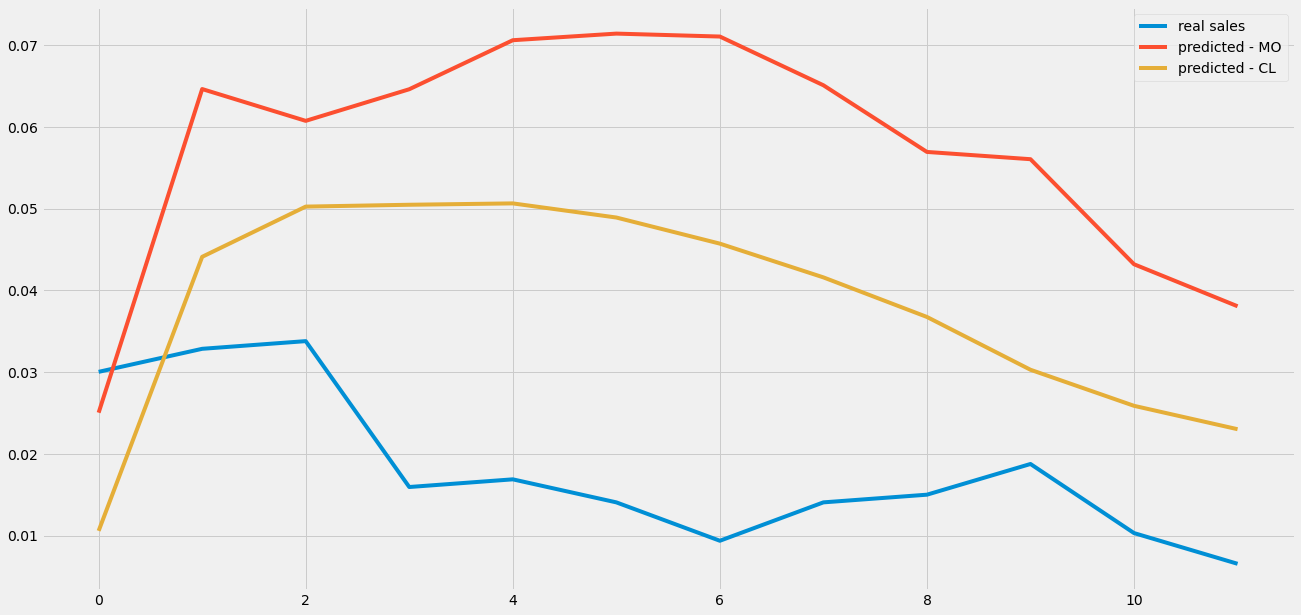

In [30]:
ii = 12 
plt.plot(y0.values[ii,:], label = "real sales")
plt.plot(mo_prediction[ii,:], label = "predicted - MO")
plt.plot(cl_prediction[ii,:], label = "predicted - CL")
plt.legend()
plt.show()

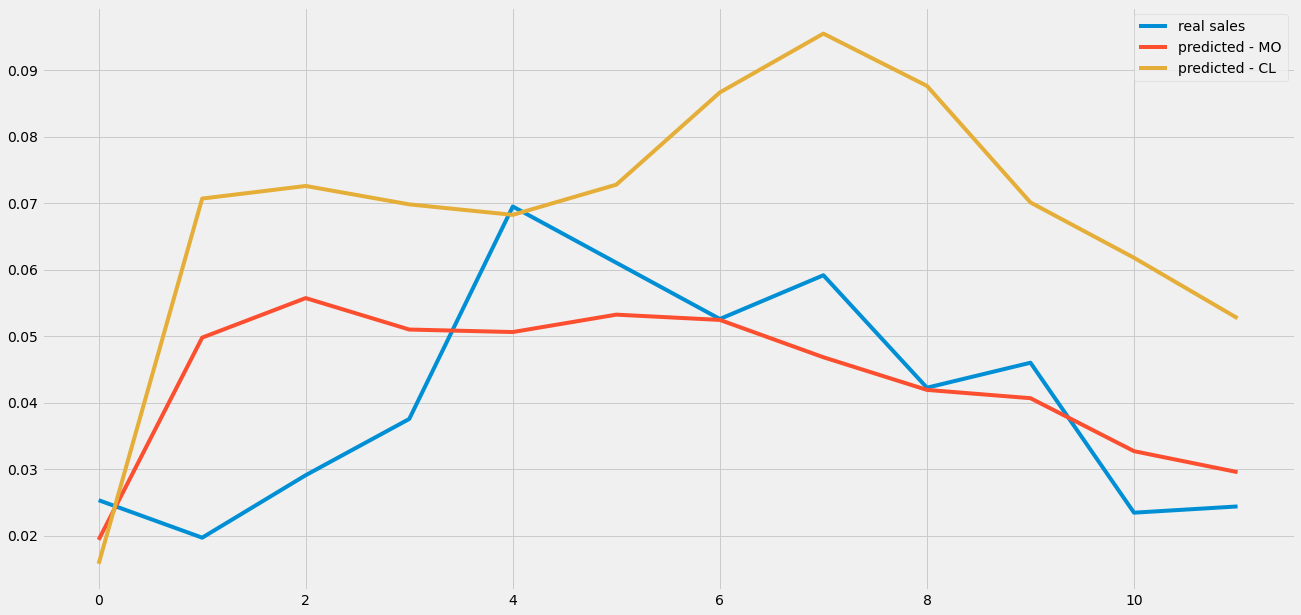

In [31]:
ii = 80
plt.plot(y0.values[ii,:], label = "real sales")
plt.plot(mo_prediction[ii,:], label = "predicted - MO")
plt.plot(cl_prediction[ii,:], label = "predicted - CL")
plt.legend()
plt.show()